# Nifty 50 Partial Replication

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("always", category=ConvergenceWarning)
import seaborn as sns

import xgboost as xgb
from sklearn.feature_selection import SelectFromModel,mutual_info_regression

In [2]:
def tracking_error(y_true, y_pred):
    # Convert y_true and y_pred to pandas Series for easy handling of pct_change()
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    
    # Calculate percentage change for true values and predictions
    # pct_change_true = y_true.pct_change() * 100
    # pct_change_pred = y_pred.pct_change() * 100
    
    # Calculate the difference between the percentage changes
    diff_pct_change = y_true - y_pred    
    
    # Return the standard deviation of the differences (tracking error)
    return np.std(diff_pct_change.dropna())  # dropna() to avoid NaN values in pct_change

In [3]:
def adj_tracking_error(y_true, X_test, model):
    cost = 0.001  # 0.1% cost
    X_test_adjusted = X_test.copy()
    X_test_adjusted[0, :] -= cost  # Subtract cost from the first return of each stock

    # Predict with adjustment
    y_pred_adjusted = model.predict(X_test_adjusted)
    return tracking_error(y_true, y_pred_adjusted)

## Data

In [4]:
# directory_path = '/kaggle/input/stock-market-data-nifty-50-stocks-1-min-data'
# pattern = os.path.join(directory_path, "*.csv")  # Change "*.csv" to match other patterns if needed

# Get the list of files that match the pattern
# file_list = glob.glob(pattern)

In [5]:
def fetch_data(cols):
    df_list = []
    for file in tqdm(file_list):
        stock_name = os.path.basename(file).split("_")[0]
        file_df = pd.read_csv(file, index_col=0)
        file_df = file_df[[cols]]
        file_df.columns = pd.MultiIndex.from_product([[stock_name], file_df.columns])
        df_list.append(file_df)
    return pd.concat(df_list, axis=1)

In [6]:
# df = fetch_data('close')
# df.to_csv('/kaggle/input/nifty_50_closing.csv')

In [7]:
df = pd.read_csv('/kaggle/input/nifty-50-closing-data/nifty_50_closing.csv', index_col=0, header=[0, 1])
df = df.xs('close', level=1, axis=1)
df.index = pd.to_datetime(df.index)

nan_rows = df.isna().any(axis=1)

# Get the number of rows with NaN values
num_nan_rows = nan_rows.sum()

print(f"Number of rows with NaN values: {num_nan_rows}")

Number of rows with NaN values: 639555


In [8]:
nifty_100_closing = pd.read_csv('/kaggle/input/nifty-50-minute-data/NIFTY 100_minute.csv', index_col=0)[['close']]
nifty_100_closing.index = pd.to_datetime(nifty_100_closing.index)
nifty_100_closing.rename(columns={'close': 'NIFTY_100'}, inplace=True)

In [9]:
print(f"Index type for df1: {type(df.index)}")
print(f"Index type for df2: {type(nifty_100_closing.index)}")

Index type for df1: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index type for df2: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [10]:
# df.interpolate(method='linear', inplace=True)
# To fill the first row NaN with the value from the next minute
threshold = 0.10

# Drop columns with more than the threshold percentage of missing values
df = df.dropna(thresh=int((1-threshold) * len(df)), axis=1)

# Get the number of rows with any 0.0 values

df.fillna(0, inplace=True)
df.index = df.index.tz_localize(None)

zero_rows = (df == 0.0).any(axis=1)


num_zero_rows = zero_rows.sum()

print(f"Number of rows with 0.0 values: {num_zero_rows}")
print(f"Total rows {len(df)}")
df.head(3)

Number of rows with 0.0 values: 37286
Total rows 677188


,APOLLOHOSP,BOSCHLTD,INDUSTOWER,BERGEPAINT,MARICO,SBIN,SUNPHARMA,COALINDIA,WIPRO,BAJAJ-AUTO,...,BIOCON,DABUR,SAIL,BRITANNIA,ADANIPORTS,ONGC,EICHERMOT,TECHM,JINDALSTEL,HEROMOTOCO
date,,,,,,,,,,,,,,,,,,,,,
2018-08-06 10:47:00,974.3,19187.45,290.0,316.85,357.95,306.70,579.65,282.05,207.93,2695.00,...,287.40,435.30,79.35,3194.92,400.70,167.75,2711.3,670.45,207.65,3259.0
2018-08-06 10:48:00,973.7,19187.45,290.0,316.50,357.55,306.70,579.30,282.05,207.93,2695.00,...,287.75,435.15,79.30,3193.02,400.55,167.55,2710.6,670.55,207.80,3260.6
2018-08-06 10:49:00,973.7,19187.45,290.0,316.85,357.20,306.75,579.45,282.00,207.97,2697.95,...,287.95,435.70,79.30,3192.50,400.30,167.55,2709.8,670.65,207.55,3259.5


In [11]:
len(df.columns)

88

In [12]:
df_total = df.join(nifty_100_closing, how='left')

In [13]:
df_total.dropna(inplace=True)

In [14]:
# Calculate the percentage change
X_pct_change = df_total.pct_change()

# Define the threshold for large changes (e.g., 100% change)
threshold = 1.0  # 1.0 corresponds to 100% when working with pct_change()

# Find rows with any column having a percentage change greater than the threshold
large_change_rows = X_pct_change[(X_pct_change.abs() > threshold).any(axis=1)]

# Get the number of rows where there are large percentage changes
num_large_changes = large_change_rows.shape[0]

print(f"Number of rows with large changes (>{threshold * 100}%): {num_large_changes}")

Number of rows with large changes (>100.0%): 14551


In [15]:
print(len(df_total))

666554


# Models

## Combined Approach
In this section, we will utilize a combined approach to limit the number of features (stocks) and train our models.

1. Feature Selection (using Lasso w/ high alpha, Mutual Info, ANOVA, RFE)
2. Define threshold to drop features
3. Train model on reduced feature space (Hyperparameter tuned)
4. Get tracking error
5. Save pair (number of stocks, tracking error) for plotting

### Lasso - Lasso

We will utilize a Lasso model with a high alpha value to perform feature selection, this will drop the coefficients for less important features to 0. After that we retrain a Lasso model with hyperparameter tuning.

In [16]:
from sklearn.preprocessing import StandardScaler

def Lasso_Lasso(alpha, X, y):    
    tscv = TimeSeriesSplit(n_splits=5)
    stocks = []
    num_stocks = []
    fold_scores = []
    adj_fold_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)
        
        # Feature selection with alpha from list
        lasso_fs = Lasso(alpha=alpha, max_iter=200)
        lasso_fs.fit(X_scaled, y_train_cv)

        #for feature, coef in zip(X_train_cv.columns, lasso_fs.coef_):
        #    print(f"{feature}: {coef}")

        selector = SelectFromModel(lasso_fs, threshold=10e-10, max_features=None)  # Adjust threshold as needed
        X_selected_train = selector.transform(X_scaled)
        X_selected_test = selector.transform(X_test_cv)

        selected_features = np.where(selector.get_support())[0] 
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_alpha = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for alph in [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025]:
            lasso = Lasso(alpha=alph, max_iter=15000)
            lasso.fit(X_selected_train, y_train_cv)
    
            y_pred = lasso.predict(X_selected_test)
            fold_score = tracking_error(y_test_cv.values, y_pred)
            adj_fold_score = adj_tracking_error(y_test_cv.values, X_selected_test, lasso)
            # print(f"Alpha: {alpha}, Fold Score: {fold_score}")
    
            if fold_score < best_score:
                best_score = fold_score
                best_alpha = alpha
    
        print(f"Best Alpha for this fold: {best_alpha}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)
        adj_fold_scores.append(adj_fold_score)
        
    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)
    average_adj_score = np.mean(adj_fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)
    
    # Print the tracking error for this alpha
    print(f"Alpha: {alpha}, Average Tracking Error: {average_score}")
 
    return stocks, average_selected_features, average_score, average_adj_score

Starting alpha 0.001
Selected 76 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.081909105203533


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e-01, tolerance: 1.155e-01
  model = cd_fast.enet_coordinate_descent(


Selected 81 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.046037244453767584


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e-01, tolerance: 1.462e-01
  model = cd_fast.enet_coordinate_descent(


Selected 83 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.14422887657558622


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.557e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 74 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.0383524818658657


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.174e+00, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 75 stocks
Best Alpha for this fold: 0.001, Best Fold Score: 0.3565449495774766
Alpha: 0.001, Average Tracking Error: 0.13341453153524582
Starting alpha 0.002
Selected 66 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.081967866586919
Selected 74 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.04606473569976823
Selected 77 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.14399135618974615


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.950e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 64 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.03837519106221485


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.450e+00, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 64 stocks
Best Alpha for this fold: 0.002, Best Fold Score: 0.35637819505785867
Alpha: 0.002, Average Tracking Error: 0.13335546891930136
Starting alpha 0.003
Selected 56 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.08210486980390885
Selected 69 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.04608800889113797
Selected 67 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.14327933052165037


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.406e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 57 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.038480376789333796


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.592e+00, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 59 stocks
Best Alpha for this fold: 0.003, Best Fold Score: 0.35649484651488567
Alpha: 0.003, Average Tracking Error: 0.13328948650418332
Starting alpha 0.004
Selected 44 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.08233188045251498
Selected 60 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.04611325065902526
Selected 60 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.14356065245140887


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 51 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.038514680186667795


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.612e+00, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 49 stocks
Best Alpha for this fold: 0.004, Best Fold Score: 0.3572116969907556
Alpha: 0.004, Average Tracking Error: 0.13354643214807452
Starting alpha 0.005
Selected 37 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.08246575545463884
Selected 53 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.046092955003324845
Selected 53 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.14361783756516072


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.659e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 47 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.03857262394898608


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e+00, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 48 stocks
Best Alpha for this fold: 0.005, Best Fold Score: 0.35715728029271204
Alpha: 0.005, Average Tracking Error: 0.13358129045296452
Starting alpha 0.006
Selected 30 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.0825208924094347
Selected 48 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.046140596679281685
Selected 48 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.14338597079294838


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.403e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 43 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.038640205725251564


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+00, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 41 stocks
Best Alpha for this fold: 0.006, Best Fold Score: 0.35708717471453105
Alpha: 0.006, Average Tracking Error: 0.1335549680642895
Starting alpha 0.007
Selected 24 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.08266331200365212
Selected 41 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.046187531388854924
Selected 40 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.14340692496266386


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 40 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.03861779160285179


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.008e-01, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 38 stocks
Best Alpha for this fold: 0.007, Best Fold Score: 0.35732481482317086
Alpha: 0.007, Average Tracking Error: 0.1336400749562387
Starting alpha 0.008
Selected 21 stocks
Best Alpha for this fold: 0.008, Best Fold Score: 0.0829232139459467
Selected 36 stocks
Best Alpha for this fold: 0.008, Best Fold Score: 0.046209090142064924
Selected 37 stocks
Best Alpha for this fold: 0.008, Best Fold Score: 0.14368580630065705


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 39 stocks
Best Alpha for this fold: 0.008, Best Fold Score: 0.03861370764104398


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.697e-01, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 38 stocks
Best Alpha for this fold: 0.008, Best Fold Score: 0.35732481482317086
Alpha: 0.008, Average Tracking Error: 0.1337513265705767
Starting alpha 0.009
Selected 19 stocks
Best Alpha for this fold: 0.009, Best Fold Score: 0.0831815533631772
Selected 33 stocks
Best Alpha for this fold: 0.009, Best Fold Score: 0.04625449885301737
Selected 32 stocks
Best Alpha for this fold: 0.009, Best Fold Score: 0.14380290717850114


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.168e+00, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 36 stocks
Best Alpha for this fold: 0.009, Best Fold Score: 0.038700665766585075


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.150e-01, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 36 stocks
Best Alpha for this fold: 0.009, Best Fold Score: 0.3572410680403312
Alpha: 0.009, Average Tracking Error: 0.1338361386403224
Starting alpha 0.01
Selected 18 stocks
Best Alpha for this fold: 0.01, Best Fold Score: 0.08322095681811198
Selected 28 stocks
Best Alpha for this fold: 0.01, Best Fold Score: 0.0463170832242172
Selected 31 stocks
Best Alpha for this fold: 0.01, Best Fold Score: 0.14320508563757445


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.834e-01, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 35 stocks
Best Alpha for this fold: 0.01, Best Fold Score: 0.038724908292294434


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.735e-01, tolerance: 4.596e-01
  model = cd_fast.enet_coordinate_descent(


Selected 34 stocks
Best Alpha for this fold: 0.01, Best Fold Score: 0.3573771084531077
Alpha: 0.01, Average Tracking Error: 0.13376902848506117
Starting alpha 0.011
Selected 17 stocks
Best Alpha for this fold: 0.011, Best Fold Score: 0.08320520498079921
Selected 28 stocks
Best Alpha for this fold: 0.011, Best Fold Score: 0.0463170832242172
Selected 24 stocks
Best Alpha for this fold: 0.011, Best Fold Score: 0.14345719003603022


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.855e-01, tolerance: 4.375e-01
  model = cd_fast.enet_coordinate_descent(


Selected 33 stocks
Best Alpha for this fold: 0.011, Best Fold Score: 0.038723784809585104
Selected 33 stocks
Best Alpha for this fold: 0.011, Best Fold Score: 0.357351363580298
Alpha: 0.011, Average Tracking Error: 0.13381092532618594
Starting alpha 0.012
Selected 15 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.08350457886653427
Selected 25 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.046410775660491115
Selected 24 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.14345719003603022
Selected 30 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.038709678096388686
Selected 29 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.3573471145912843
Alpha: 0.012, Average Tracking Error: 0.13388586745014572


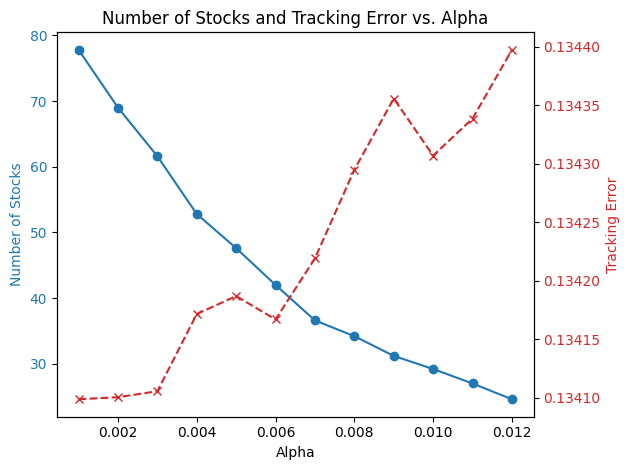

In [17]:
df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = 100*df_total_returns
X = df_total_returns.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total_returns['NIFTY_100']

alphas = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012]
tracking_errors = []
adj_tracking_errors = []
num_stocks_list = []

for alpha in alphas:
    print(f"Starting alpha {alpha}")
    _, num_stocks, tracking_err, adj_tracking_err = Lasso_Lasso(alpha, X, y)
    num_stocks_list.append(num_stocks)
    tracking_errors.append(tracking_err)
    adj_tracking_errors.append(adj_tracking_err)

# Plotting the results
fig, ax1 = plt.subplots()

# Plotting number of stocks on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Number of Stocks', color=color)
ax1.plot(alphas, num_stocks_list, color=color, marker='o', label='Number of Stocks')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for tracking error
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Tracking Error', color=color)
#ax2.plot(alphas, tracking_errors, color='tab:green', marker='o', linestyle='--', label='Tracking Error')
ax2.plot(alphas, adj_tracking_errors, color=color, marker='x', linestyle='--', label='Adjusted Tracking Error')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title and legend
plt.title('Number of Stocks and Tracking Error vs. Alpha')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Mutual Info - Lasso
Using mutual information between variables, which measures the dependency between them, 0 value being independence. By getting the mutual information between the features (stocks) and the target (NIFTY 100) we can "discard" the variables with lower dependencies. After feature selection, we traing a Lasso model with CV.

In [18]:
from sklearn.preprocessing import StandardScaler

def MI_Lasso(percentile, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    stocks = []
    num_stocks = []
    fold_scores = []
    adj_fold_scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)

        # Feature selection with alpha from list
        mi_scores = mutual_info_regression(X_train_cv, y_train_cv)
        mi_scores_series = pd.Series(mi_scores, index=X_train_cv.columns)

        threshold_value = mi_scores_series.quantile(percentile)
        
        selected_features = mi_scores_series[mi_scores_series > threshold_value].index
        selected_indices = [X_train_cv.columns.get_loc(feature) for feature in selected_features]

        # Filter the NumPy arrays based on the selected feature indices
        X_train_selected = X_scaled[:, selected_indices]
        X_test_selected = X_test_cv.to_numpy()[:, selected_indices]
    
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_alpha = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for alph in [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025]:
            lasso = Lasso(alpha=alph, max_iter=15000)
            lasso.fit(X_train_selected, y_train_cv)
    
            y_pred = lasso.predict(X_test_selected)
            fold_score = tracking_error(y_test_cv.values, y_pred)
            adj_fold_score = adj_tracking_error(y_test_cv.values, X_test_selected, lasso)
            # print(f"Alpha: {alpha}, Fold Score: {fold_score}")
    
            if fold_score < best_score:
                best_score = fold_score
                best_alpha = alpha
    
        print(f"Best Alpha for this fold: {best_alpha}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)
        adj_fold_scores.append(adj_fold_score)
        
    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)
    average_adj_score = np.mean(adj_fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)
    
    # Print the tracking error for this alpha
    print(f"Alpha: {alpha}, Average Tracking Error: {average_score}")
 
    return stocks, average_selected_features, average_score, average_adj_score

Starting percentile: 0.0
Selected 85 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.08188559257044299
Selected 85 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.04602493200009013
Selected 85 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.14422903399979942
Selected 85 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.03827165938844949
Selected 85 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.35639557847855263
Alpha: 0.012, Average Tracking Error: 0.13336135928746695
Starting percentile: 0.1
Selected 77 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.08192350470222762
Selected 77 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.046038646979394894
Selected 77 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.14422132585040384
Selected 77 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.03826250367215357
Selected 77 stocks
Best Alpha for this fold: 0.012, Best Fold Score: 0.35633760664763725
A

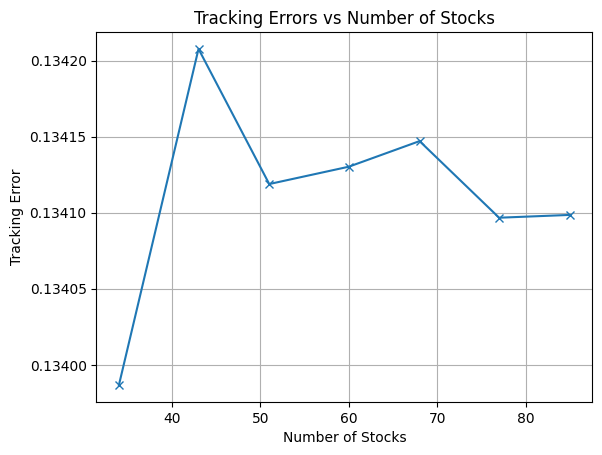

In [19]:
df_total_z = df_total.replace(0, np.nan)  # Convert zeroes back to NaNs
df_total_returns = df_total_z.pct_change().dropna()
df_total_returns = 100*df_total_returns
X = df_total_returns.drop(columns=['NIFTY 50', 'NIFTY BANK', 'NIFTY_100'])
y = df_total_returns['NIFTY_100']

alphas = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012]
tracking_errors = []
adj_tracking_errors = []
num_stocks_list = []

percentiles = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for percentile in percentiles:
    print(f"Starting percentile: {percentile}")
    _, num_stocks, tracking_err, adj_tracking_err = MI_Lasso(percentile, X, y)
    num_stocks_list.append(num_stocks)
    tracking_errors.append(tracking_err)
    adj_tracking_errors.append(adj_tracking_err)

# Plotting the results
fig, ax1 = plt.subplots()

# Plotting number of stocks on the primary y-axis
plt.plot(num_stocks_list, adj_tracking_errors, marker='x')
plt.xlabel('Number of Stocks')
plt.ylabel('Tracking Error')
plt.title('Tracking Errors vs Number of Stocks')
plt.grid(True)
plt.show()

TODO: Theil-Sein Linear Regression